## Game of Thrones - machine learning to predict character death

Source: https://github.com/bigpress/gameofthrones 

In [1]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib

You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 10.1MB 4.9MB/s eta 0:00:01
You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 215kB 29.6MB/s ta 0:00:01
    100% |████████████████████████████████| 13.0MB 3.3MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 30.4MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 30.7MB/s ta 0:00:01
You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches
sns.set_style("white")

In [4]:
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [15., 6.]

In [18]:
battles = pd.read_csv("./battles.csv")
character_deaths = pd.read_csv("./character-deaths.csv")
character_predictions = pd.read_csv("./character-predictions.csv")

battles.head(5)

,name,year,battle_number,attacker_king,defender_king,attacker_1,attacker_2,attacker_3,attacker_4,defender_1,...,major_death,major_capture,attacker_size,defender_size,attacker_commander,defender_commander,summer,location,region,note
0,Battle of the Golden Tooth,298,1,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Tully,...,1.0,0.0,15000.0,4000.0,Jaime Lannister,"Clement Piper, Vance",1.0,Golden Tooth,The Westerlands,NaN
1,Battle at the Mummer's Ford,298,2,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Baratheon,...,1.0,0.0,NaN,120.0,Gregor Clegane,Beric Dondarrion,1.0,Mummer's Ford,The Riverlands,NaN
2,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Tully,...,0.0,1.0,15000.0,10000.0,"Jaime Lannister, Andros Brax","Edmure Tully, Tytos Blackwood",1.0,Riverrun,The Riverlands,NaN
3,Battle of the Green Fork,298,4,Robb Stark,Joffrey/Tommen Baratheon,Stark,NaN,NaN,NaN,Lannister,...,1.0,1.0,18000.0,20000.0,"Roose Bolton, Wylis Manderly, Medger Cerwyn, H...","Tywin Lannister, Gregor Clegane, Kevan Lannist...",1.0,Green Fork,The Riverlands,NaN
4,Battle of the Whispering Wood,298,5,Robb Stark,Joffrey/Tommen Baratheon,Stark,Tully,NaN,NaN,Lannister,...,1.0,1.0,1875.0,6000.0,"Robb Stark, Brynden Tully",Jaime Lannister,1.0,Whispering Wood,The Riverlands,NaN


## New attributes
1. *defender_count* – Number of major houses on defending side
2. *attacker_count* – Number of major houses on attacking side
3. *att_comm_count* – Number of commanders on attacking side
4. *no_of_books* – Number of books a character appeared in

In [19]:
battles.loc[:, "defender_count"] = (4 - battles[["defender_1", "defender_2", "defender_3", "defender_4"]].isnull().sum(axis = 1))
battles.loc[:, "attacker_count"] = (4 - battles[["attacker_1", "attacker_2", "attacker_3", "attacker_4"]].isnull().sum(axis = 1))
battles.loc[:, "att_comm_count"] = [len(x) if type(x) == list else np.nan for x in battles.attacker_commander.str.split(",")]
character_predictions.loc[:, "no_of_books"] = character_predictions[[x for x in character_predictions.columns if x.startswith("book")]].sum(axis = 1)

# Exploratory Analysis

## Major death/capture events by year

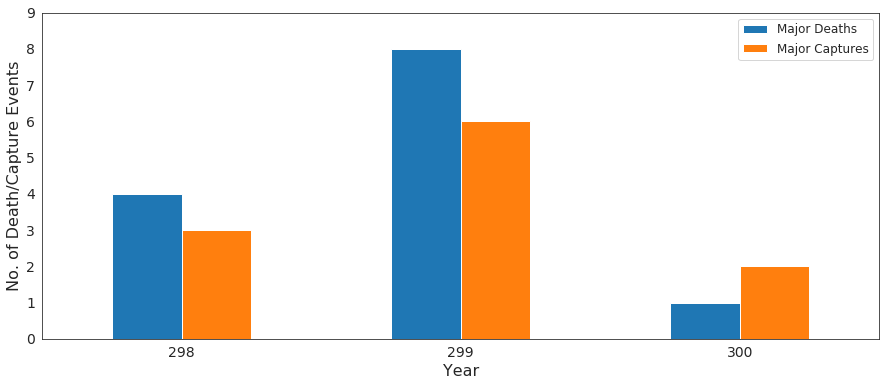

In [20]:
p = battles.groupby('year').sum()[["major_death", "major_capture"]].plot.bar(rot = 0)
_ = p.set(xlabel = "Year", ylabel = "No. of Death/Capture Events", ylim = (0, 9)), p.legend(["Major Deaths", "Major Captures"])

## How often were there more than one major houses on the attacking side?

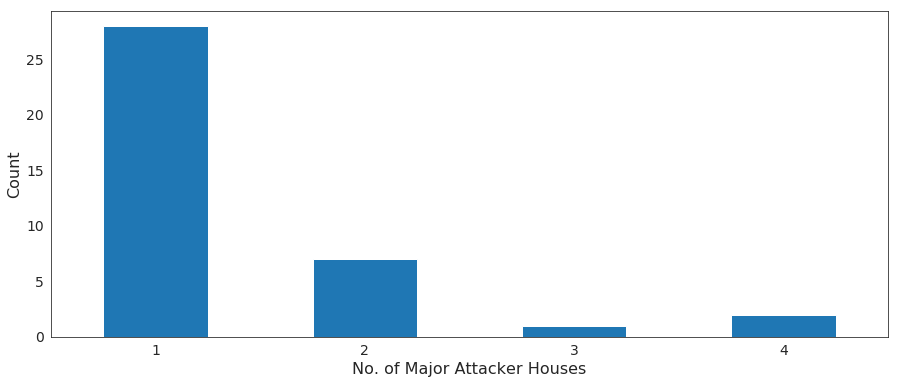

In [21]:
p = battles.attacker_count.value_counts().sort_index().plot.bar(rot = 0)
_ = p.set(xlabel = "No. of Major Attacker Houses", ylabel = "Count")

## Which pairs fought the most battles?

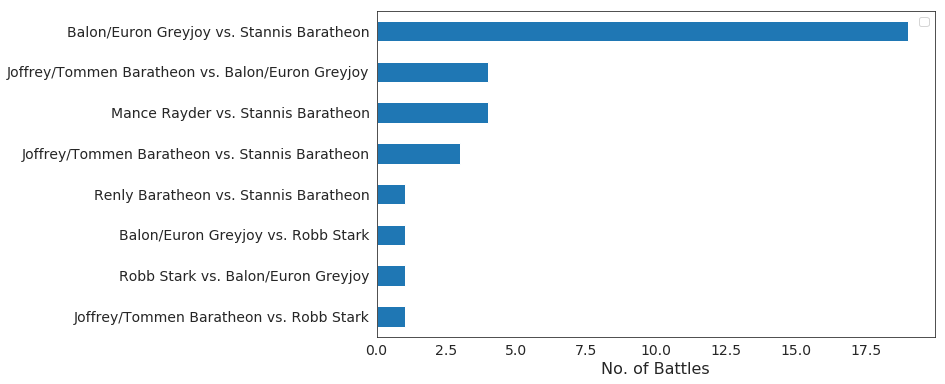

In [22]:
#Ignoring records where either attacker_king or defender_king is null. Also ignoring one record where both have the same value.
c = list(Counter([tuple(set(x)) for x in battles.dropna(subset = ["attacker_king", "defender_king"])[["attacker_king", "defender_king"]].values if len(set(x)) > 1]).items())
p = pd.DataFrame(c).sort_values(1).plot.barh(figsize = (10, 6))
_ = p.set(yticklabels = ["%s vs. %s" % (x[0], x[1]) for x in list(zip(*c))[0]], xlabel = "No. of Battles"), p.legend("")

## How many commanders did armies of different kings have?

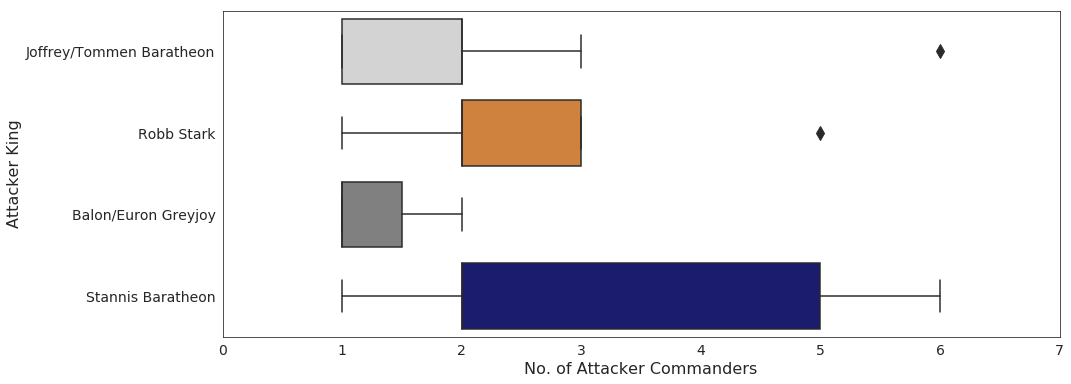

In [23]:
p = sns.boxplot("att_comm_count", "attacker_king", data = battles, saturation = .6, fliersize = 10., palette = ["lightgray", sns.color_palette()[1], "grey", "darkblue"])
_ = p.set(xlabel = "No. of Attacker Commanders", ylabel = "Attacker King", xticks = range(8))

## How many major death/capture events occur in each region?

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


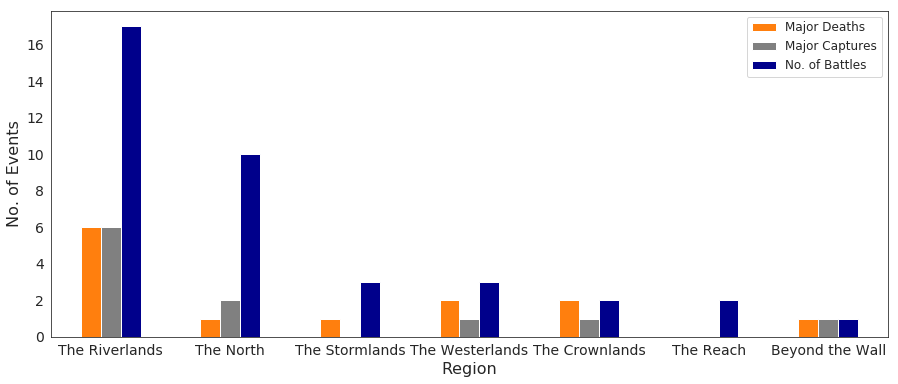

In [25]:
data = battles.groupby("region").sum()[["major_death", "major_capture"]]
p = pd.concat([data, battles.region.value_counts().to_frame()], axis = 1).sort_values("region", ascending = False).copy(deep = True).plot.bar(color = [sns.color_palette()[1], "grey", "darkblue"], rot = 0)
_ = p.set(xlabel = "Region", ylabel = "No. of Events"), p.legend(["Major Deaths", "Major Captures", "No. of Battles"], fontsize = 12.)

## Is there a relationship between survival and having dead relations?

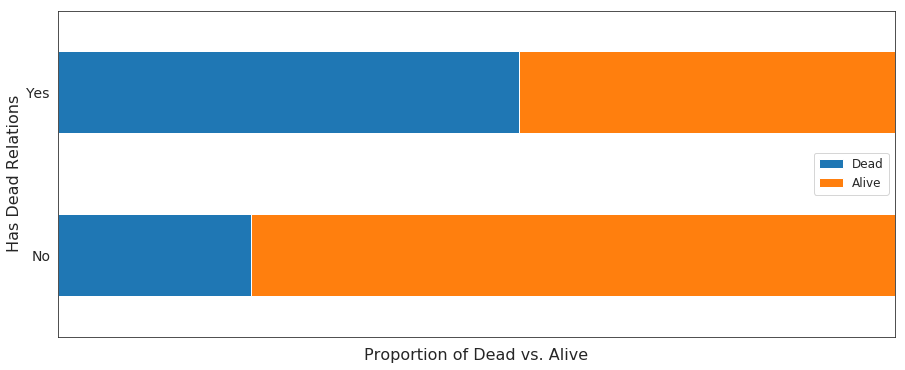

In [26]:
data = character_predictions.groupby(["boolDeadRelations", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, width = .5)
_ = p.set_xlim([0, 1]), p.set(yticklabels = ["No", "Yes"], xticklabels = "", xlabel = "Proportion of Dead vs. Alive", ylabel = "Has Dead Relations"), p.legend(["Dead", "Alive"])

## How does appearing in more books relate to survival?

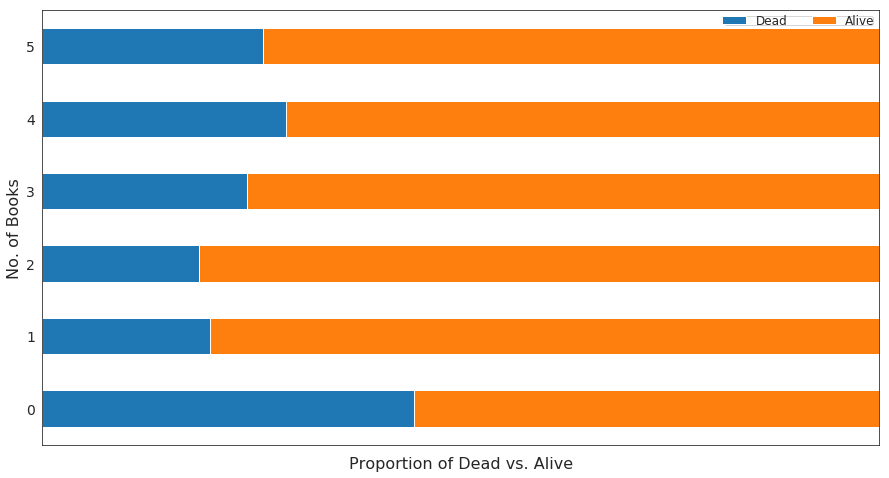

In [27]:
data = character_predictions.groupby(["no_of_books", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, figsize = (15, 8), width = .5)
_ = p.set(xticklabels = "", xlim = [0, 1], ylabel = "No. of Books", xlabel = "Proportion of Dead vs. Alive"), p.legend(["Dead", "Alive"], loc = "upper right", ncol = 2, borderpad = -.15)

## How does culture relate to survival?
For this, we will rename cultures using (ahem) domain knowledge as many of the culture values map to a single culture.

In [28]:
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

def get_cult(value):
    value = value.lower()
    v = [k for (k, v) in cult.items() if value in v]
    return v[0] if len(v) > 0 else value.title()

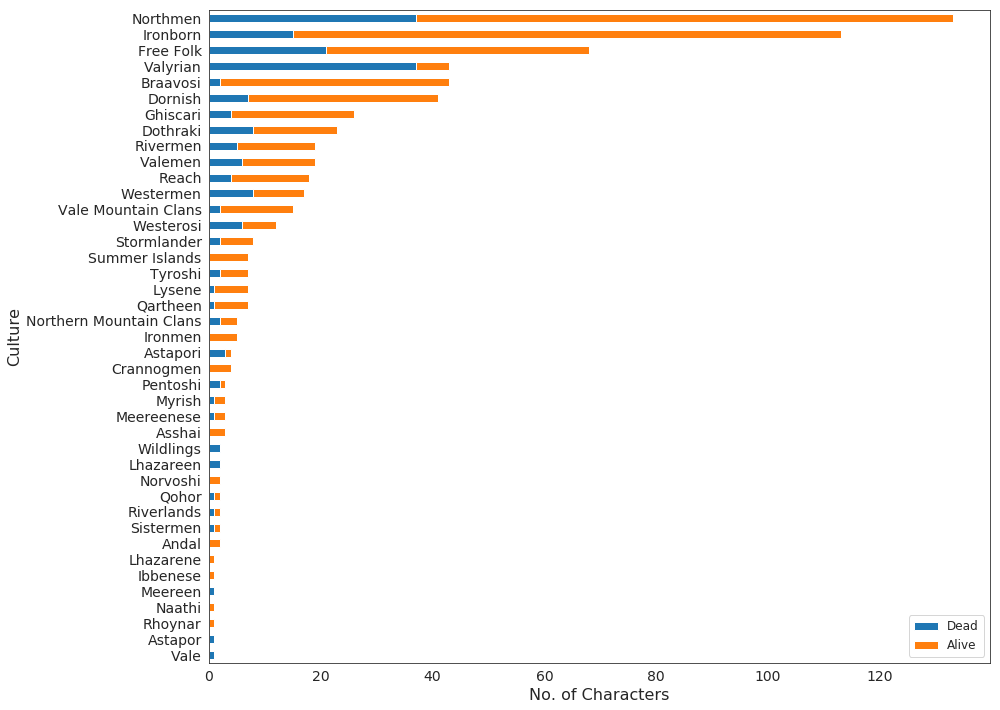

In [29]:
character_predictions.loc[:, "culture"] = [get_cult(x) for x in character_predictions.culture.fillna("")]
data = character_predictions.groupby(["culture", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
data.loc[:, "total"]= data.sum(axis = 1)
p = data[data.index != ""].sort_values("total")[[0, 1]].plot.barh(stacked = True, rot = 0, figsize = (14, 12),)
_ = p.set(xlabel = "No. of Characters", ylabel = "Culture"), p.legend(["Dead", "Alive"], loc = "lower right")

## Do larger armies necessarily win?
The results for this one are, well, weird as you can see.

To be fair, though, I have only considered battles with valid values for *attacker\_size* and *defender\_size*, which reduces the record count to 16 down from 37. I am not a GoT fan (yet) nor have I watched the TV series.

I read about one of the battles with `NaN` *attacker\_size* on the [GoT Wikia](http://gameofthrones.wikia.com/wiki/Battle_at_the_Mummer's_Ford), wherein the following is stated under the _Forces_ section:
> A raiding party was reported by the Riverlands smallfolk refugees but the Iron Throne detachment was met by a considerably larger force.

Based on this, if we assumed that *attacker\_size* was larger, it would count in favor of the position that larger armies are likelier to win. However, we do not have this data for the remaining 20 battles so we cannot say anything conclusively.

**If you are knowledgeable about GoT, do comment below on this.**

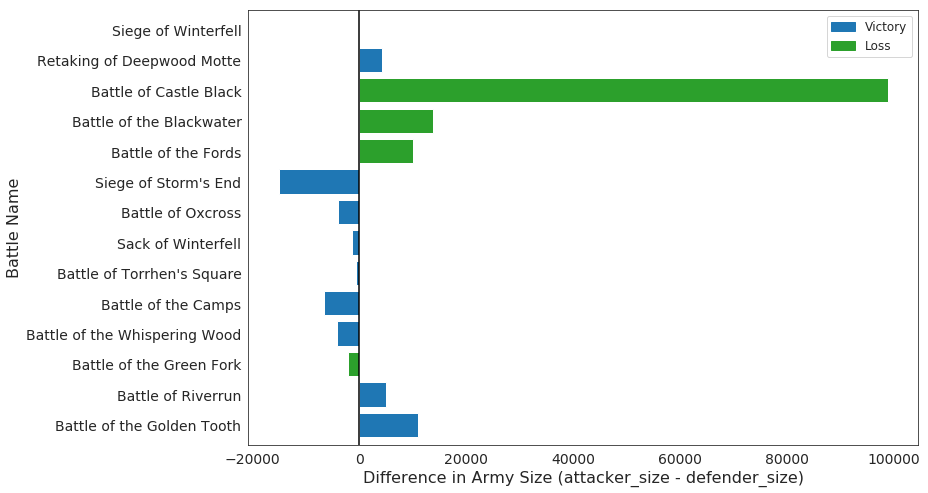

In [30]:
data = battles.dropna(subset = ["attacker_size", "defender_size"]).copy(deep = True)
data = pd.concat([(data.attacker_size - data.defender_size).to_frame(), battles[["attacker_outcome"]]], axis = 1, join = "inner")
data = data[data[0] != 0]
p = data[0].plot.barh(figsize = (12, 8), width = .8, color = [sns.color_palette()[0] if x == "win" else sns.color_palette()[2] if x == "loss" else "white" for x in data.attacker_outcome.values])
_ = p.legend(handles = [mpatches.Patch(color = sns.color_palette()[0], label = "Victory", aa = True), mpatches.Patch(color = sns.color_palette()[2], label = "Loss", aa = True)])
_ = p.axvline(0, color = 'k'), p.set(yticklabels = battles.name.iloc[data.index].values, xlabel = "Difference in Army Size (attacker_size - defender_size)", ylabel = "Battle Name")

## How often did kings fight different types of battles?
The data contains four types of battles of which _Pitched Battle_ is the most frequent and _Razing_ the least.

It turns out that _Ambush_ seems to be Robb Stark's favorite type of attack. All five of his _Ambush_ type battles are against Joffrey/Tommen Baratheon. Robb Stark has also been a target of an ambush: twice by Balon/Euron Greyjoy and thrice by Joffrey/Tommen Baratheon.

Balon/Euron Greyjoy has fought each type of battle at least once as an attacker while Joffrey/Tommen Baratheon has done so as a defender.

See chart below.

*(Using code from matplotlib's radar chart [example](http://matplotlib.org/examples/api/radar_chart.html).)*

    100% |████████████████████████████████| 6.6MB 6.1MB/s eta 0:00:01
    100% |████████████████████████████████| 286kB 36.9MB/s ta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


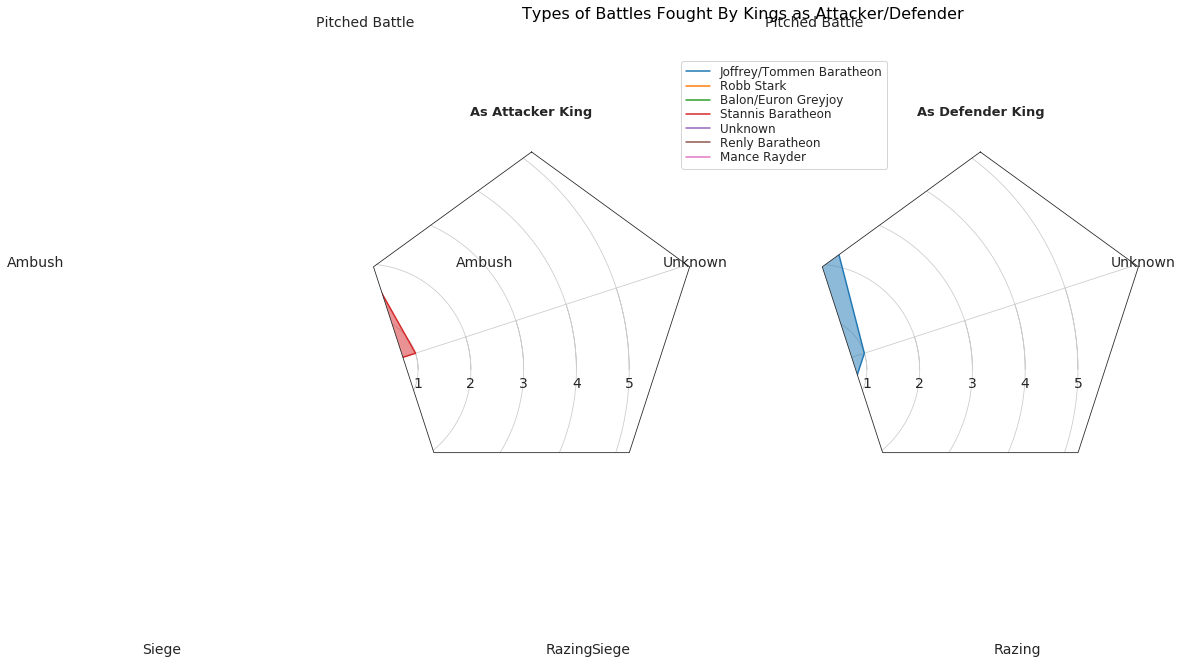

In [34]:
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

def radar_factory(num_vars, frame = "circle"):
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint = False)
    theta += np.pi / 2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed = True, edgecolor = 'k')

    def draw_circle_patch(self):
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict: raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):
        name, RESOLUTION, draw_patch = 'radar', 1, patch_dict[frame]

        def fill(self, *args, **kwargs):
            closed = kwargs.pop("closed", True)
            return super(RadarAxes, self).fill(closed = closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines: self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == "circle": return PolarAxes._gen_axes_spines(self)
            spine_type, verts = "circle", unit_poly_verts(theta)
            verts.append(verts[0])
            path = Path(verts)
            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}
    register_projection(RadarAxes)
    return theta

def unit_poly_verts(theta):
    x0, y0, r = [0.5] * 3
    verts = [(r * np.cos(t) + x0, r * np.sin(t) + y0) for t in theta]
    return verts

kings = list(battles.attacker_king.append(battles.defender_king).fillna("Unknown").unique())
battle_types = list(battles.battle_type.fillna("Unknown").str.title().unique())

def example_data():
    data = battles[["battle_type", "attacker_king", "defender_king", "name"]].copy(deep = True).fillna("Unknown")
    data.loc[:, "battle_type"] = data.battle_type.fillna("Unknown").str.title()
    grouped, ret_data = data.groupby(["attacker_king", "battle_type"]).count()[["name"]], [battle_types]
    ret_data.append(("As Attacker King", [[grouped.loc[(kings[j], battle_types[i])].values[0]
                                    if (kings[j], battle_types[i]) in grouped.index else 0
                                    for i in range(len(battle_types))] for j in range(len(kings))]))
    grouped = data.groupby(["defender_king", "battle_type"]).count()[["name"]]
    ret_data.append(("As Defender King", [[grouped.loc[(kings[j], battle_types[i])].values[0]
                                    if (kings[j], battle_types[i]) in grouped.index else 0
                                    for i in range(len(battle_types))] for j in range(len(kings))]))
    return ret_data

N = 5
theta, data = radar_factory(N, frame = "polygon"), example_data()
spoke_labels, fig = data.pop(0), plt.figure(figsize = (14, 14))
fig.subplots_adjust(wspace = 0.35, hspace = 0.20, top = 0.85, bottom = 0.05)
colors = sns.color_palette() + ["k"]
for n, (title, case_data) in enumerate(data):
    ax, _ = fig.add_subplot(2, 2, n + 1, projection = "radar"), plt.rgrids([1, 2, 3, 4, 5])
    ax.set_title(title, weight = "bold", position = (0.5, 1.1), horizontalalignment = "center", verticalalignment = "center", fontsize = 13.)
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color = color)
        ax.fill(theta, d, facecolor = color, alpha = 0.5)
    ax.set_varlabels(spoke_labels)
plt.subplot(2, 2, 1)
labels = kings
legend = plt.legend(labels, loc = (.95, .95), labelspacing = 0.1)
plt.setp(legend.get_texts(), fontsize = "large")
plt.figtext(0.5, 0.965, "Types of Battles Fought By Kings as Attacker/Defender", ha = "center", color = "k", size = 16.)
plt.show()

In [32]:
death_preds = character_predictions.copy(deep = True)

# Predictive Experiment
I have added this quick predictive experiment to complete the analysis. It does not go into too much depth. However, I will try and add more things as and when I get time.

In [35]:
!pip install sklearn
from xgboost import plot_importance
from xgboost import XGBClassifier as XGBC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score

You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## A bit of preprocessing
We quickly convert non-numeric categorical features to numeric. Then we drop some columns and replace missing values with -1.

In [36]:
death_preds.loc[:, "culture"] = [get_cult(x) for x in death_preds.culture.fillna("")]
death_preds.loc[:, "title"] = pd.factorize(death_preds.title)[0]
death_preds.loc[:, "culture"] = pd.factorize(death_preds.culture)[0]
death_preds.loc[:, "mother"] = pd.factorize(death_preds.mother)[0]
death_preds.loc[:, "father"] = pd.factorize(death_preds.father)[0]
death_preds.loc[:, "heir"] = pd.factorize(death_preds.heir)[0]
death_preds.loc[:, "house"] = pd.factorize(death_preds.house)[0]
death_preds.loc[:, "spouse"] = pd.factorize(death_preds.spouse)[0]

death_preds.drop(["name", "alive", "pred", "plod", "isAlive", "dateOfBirth"], 1, inplace = True)
death_preds.columns = map(lambda x: x.replace(".", "").replace("_", ""), death_preds.columns)
death_preds.fillna(value = -1, inplace = True)

## Is there a class imbalance?
Let us take a look at the class distribution now.

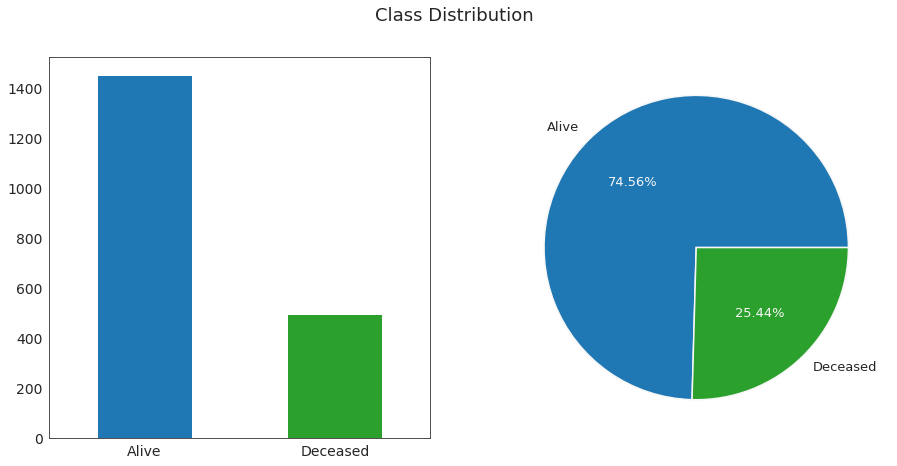

In [37]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("Class Distribution", fontsize = 18.)
_ = death_preds.actual.value_counts().plot.bar(ax = ax[0], rot = 0, color = (sns.color_palette()[0], sns.color_palette()[2])).set(xticklabels = ["Alive", "Deceased"])
_ = death_preds.actual.value_counts().plot.pie(labels = ("Alive", "Deceased"), autopct = "%.2f%%", label = "", fontsize = 13., ax = ax[1],\
colors = (sns.color_palette()[0], sns.color_palette()[2]), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), ax[1].texts[1].set_color("#F7F7F7"), ax[1].texts[3].set_color("#F7F7F7")

The class distribution indicates an imbalance. There are many more characters alive than dead. There are several well-known ways to tackle this problem.

Two of the simplest ways are undersampling and oversampling. In this case, we will undersample the majority class. We will draw ~70% samples without replacement from the minority *Deceased* class. We will draw an equal number of samples (~350) from the majority *Alive* class.

Using this train-test split we will build and compare two models: an XGB Classifier model and a Logistic Regression model.

In [38]:
X = death_preds[death_preds.actual == 0].sample(350, random_state = 62).append(death_preds[death_preds.actual == 1].sample(350, random_state = 62)).copy(deep = True).astype(np.float64)
Y = X.actual.values
tX = death_preds[~death_preds.index.isin(X.index)].copy(deep = True).astype(np.float64)
tY = tX.actual.values
X.drop(["SNo", "actual", "DateoFdeath"], 1, inplace = True)
tX.drop(["SNo", "actual", "DateoFdeath"], 1, inplace = True)

## XGB Classifier

In [40]:
!pip install sklearn
clf_xgb = XGBC(subsample = .8, colsample_bytree = .8, seed = 14, max_depth = 3).fit(X, Y)
preds_xgb = clf_xgb.predict_proba(tX)
ax = pd.DataFrame(list(clf_xgb.get_booster().get_fscore().items())).set_index(0)\
.sort_values(1).plot.barh(figsize = (12, 8))
_ = ax.set(frame_on = False, ylim = (0, len(clf_xgb.get_booster().get_fscore())), xticklabels = "", xlabel = "", ylabel = ""), ax.legend("")
_ = plt.title("XGB Feature Importance", fontsize = 18.)

You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


XGBoostError: sklearn needs to be installed in order to use this module

## Logistic Regression

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


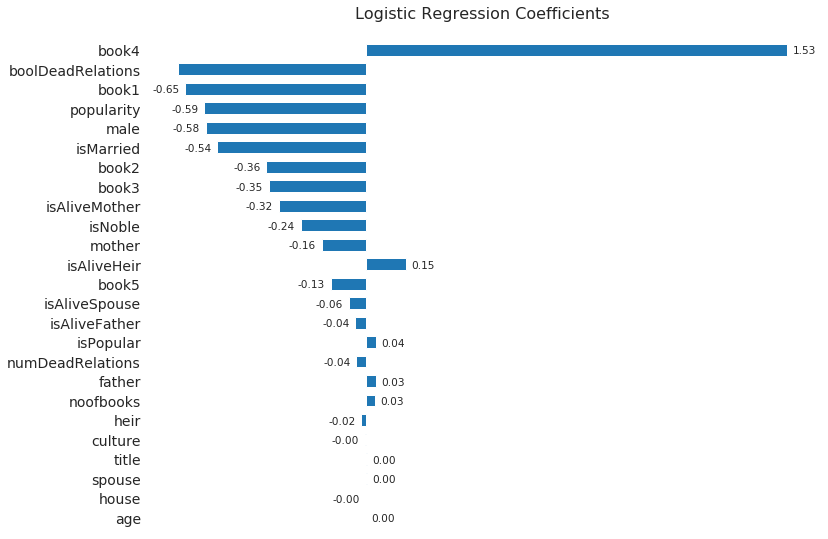

In [41]:
logreg = LogisticRegression(random_state = 14).fit(X, Y)
preds_lr = logreg.predict_proba(tX)

df = pd.DataFrame(list(zip(tX.columns, logreg.coef_[0])))
df = df.reindex(df[1].abs().sort_values().index).set_index(0)
ax = df.plot.barh(width = .6, legend = "", figsize = (12, 9))
ax.set_title("Logistic Regression Coefficients", y = 1.03, fontsize = 16.)
_ = ax.set(frame_on = False, xlabel = "", xticklabels = "", ylabel = "")

for i, label in enumerate(list(df.index)):
    score = df.loc[label][1]
    ax.annotate('%.2f' % score, (score + (-.12 if score < 0 else .02), i - .2), fontsize = 10.5)

## Comparison of XGB Classifier and Logistic Regression

### Confusion Matrix
First we see the confusion matrices for both models. We will normalize these by their row-wise sums before visualizing.

NameError: name 'preds_xgb' is not defined

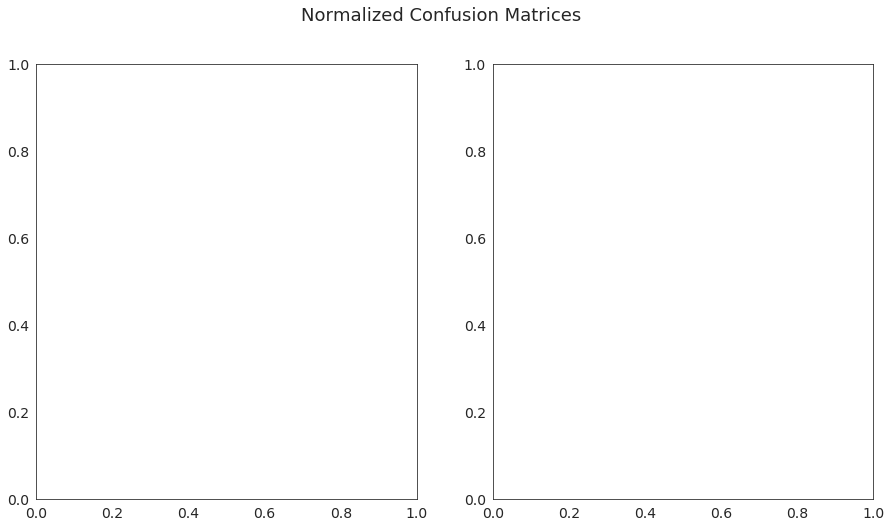

In [42]:
f, ax = plt.subplots(1, 2, figsize = (15, 8))
f.suptitle("Normalized Confusion Matrices", fontsize = 18.)
def make_cm(p, t, axis):
    cm = confusion_matrix(tY, np.argmax(p, axis = 1))
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    _ = sns.heatmap(cm, square = True, xticklabels = ["Deceased", "Alive"], annot = True,
                    annot_kws = {"fontsize": 13}, yticklabels = ["Deceased", "Alive"],
                    cbar = True, cbar_kws = {"orientation": "horizontal"}, ax = ax[axis], cmap = "Blues").set(
        xlabel = "Predicted Class", ylabel = "Actual Class", title = t)
make_cm(preds_xgb, "XGB Classifier", 0)
make_cm(preds_lr, "Logistic Regression", 1)

### Scorecard
Next, we see the scorecard of both models. We use the handy `classification_report` and a number of other functions from `sklearn.metrics` to look at different evaluation metrics such as AUC, log loss, and accuracy.

In [43]:
print("XGB Classifier Performance\n" + "=" * 26 + "\n", classification_report(tY, np.argmax(preds_xgb, axis = 1), target_names = ["Deceased", "Alive"]))
print("AUC      : %.4f" % roc_auc_score(tY, preds_xgb[:, 1]))
print("Accuracy : %.4f" % accuracy_score(tY, np.argmax(preds_xgb, axis = 1)))
print("Log Loss : %.4f\n\n" % log_loss(tY, preds_xgb[:, 1]))
print("Logistic Regression Performance\n" + "=" * 31 + "\n", classification_report(tY, np.argmax(preds_lr, axis = 1), target_names = ["Deceased", "Alive"]))
print("AUC      : %.4f" % roc_auc_score(tY, preds_lr[:, 1]))
print("Accuracy : %.4f" % accuracy_score(tY, np.argmax(preds_lr, axis = 1)))
print("Log Loss : %.4f" % log_loss(tY, preds_lr[:, 1]))

NameError: name 'preds_xgb' is not defined

### ROC Curves
Finally, we look at the ROC curves for both models.

In [44]:
_ = plt.figure(figsize = (8, 8)), plt.plot(*roc_curve(tY, preds_xgb[:, 1])[:2]), plt.plot(*roc_curve(tY, preds_lr[:, 1])[:2], c = sns.color_palette()[1]), plt.legend(["XGB Classifier", "Logistic Regression"], loc = "upper left")
_ = plt.plot((0., 1.), (0., 1.), "--k", alpha = .7), plt.xlabel("False Positive Rate"), plt.ylabel("True Positive Rate"), plt.title("ROC Curves", fontsize = 16.)

NameError: name 'preds_xgb' is not defined

<Figure size 576x576 with 0 Axes>